**This is the code acompanying our MICCAI 2017 [paper](https://link.springer.com/chapter/10.1007/978-3-319-66179-7_50) :** SD-Layer: Stain Deconvolutional Layer for CNNs in Medical Microscopic Imaging

The software requirements to run this notebook are as below:-
1. Python version 2.7
2. Keras version 1.2.1
3. Theano Version 0.9.0.dev

In [1]:
%matplotlib inline

from models import *
from utils import *

Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:02:00.0)
Using Theano backend.


*** Define Data Generators  ***

Specify required augmentations and batch size. We use vertical, horizontal flipping along with random rotations through 180 degrees as the only data augmentations while training

In [2]:
def get_datagen(folder_path):  
    # this is the augmentation configuration we will use for training
    train_datagen = ImageDataGenerator(
            vertical_flip=True,
            rotation_range=180,
            horizontal_flip=True)

    # this is a generator that will read pictures found in
    # subfolers of 'data/train', and indefinitely generate
    # batches of augmented image data
    train_generator = train_datagen.flow_from_directory(
            folder_path,  # this is the target directory        
            batch_size=64,
            shuffle=True,
            class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels
    
    return train_generator



*** Setup model with SD-Layer appended at the front. ***

1. The SD-Layer is intialized with stain matrix obtained via SVD as outlined in this [paper](https://dl.acm.org/citation.cfm?id=1700155).
2. You can find my python implementation of this method in ****macenko.py****

In [3]:
num_folds = 1
lr_init = 0.01
decay = 0.0005
num_epochs = 250
ref_img_path = 'ref_all.bmp'


model = None    

## Currently Available models are alexnet and tcnn
model = get_model('tcnn',lr_init,decay,ref_img_path)

*** Print a model Summary ***

In [4]:
print model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, None, None) 0                                            
____________________________________________________________________________________________________
embed (Lambda)                   (None, 3, 400, 400)   0           input_1[0][0]                    
____________________________________________________________________________________________________
sdlayer_1 (SDLayer)              (None, 3, 400, 400)   9           embed[0][0]                      
____________________________________________________________________________________________________
conv_1 (Convolution2D)           (None, 96, 98, 98)    34944       sdlayer_1[0][0]                  
___________________________________________________________________________________________

*** Visualize stain deconvolution acheived by SVD ***

1. This essentially generates images containing a single stain only. It is acheived by setting all except the specific stain column of ****Q**** in (3).  [Please refer to this equation in the paper
2. For example, to obtain stain 1 image, the 2nd and 3rd column of ****Q**** is set to 0.

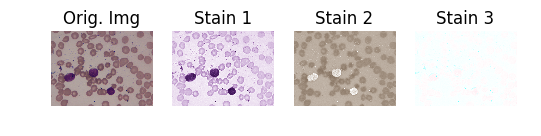

In [5]:
img = imread('ref_all.bmp')
plot_deconvolution(model,'sdlayer_1',img)

*** Train the model ***

The below cell trains and evaluates the model on the training and validation data

In [6]:
best_test_acc = 0.0
performance = {}
csv_file_name = './Train_Stats/csvlog.csv'
best_model_name = '../../Weights/best_model.hdf5'
training_images_folder_path = '../../Data/Train'
evaluating_images_folder_path = '../../Data/Val'

train_generator = get_datagen(training_images_folder_path)
lr = lr_init

for epoch in range(num_epochs): 

    if epoch == 170 or epoch == 220  :           
        lr = lr/10.0
        alexnet.optimizer.lr.set_value(lr)
        print 'Reducing learning rate to ', lr

    history = model.fit_generator(train_generator,
                                    samples_per_epoch=train_generator.nb_sample,
                                    nb_epoch=1,
                                    verbose=1)

    performance = evaluate_model_and_append(model,evaluating_images_folder_path, csv_file_name,performance, history)      
    print 'epoch : {0} - test_acc : {1} - test_f1 : {2} - test_precision : {3} - test_recall : {4}'.format(str(epoch),performance['test_acc'][-1],\
                                                                                             performance['test_f1'][-1],\
                                                                                             performance['test_prec'][-1],\
                                                                                             performance['test_rec'][-1])

    plot_performance(performance,'./Train_Stats/')

    if best_test_acc < performance['test_acc'][-1]:
        print 'best_epoch {0}'.format(epoch)
        best_test_acc = performance['test_acc'][-1]
        model.save(best_model_name)

Found 5718 images belonging to 2 classes.
Epoch 1/1
5718/5718 [==============================] - 61s - loss: 0.2468 - acc: 0.5533    
epoch : 0 - test_acc : 0.507886435331 - test_f1 : 0.673640167364 - test_precision : 1.0 - test_recall : 0.507886435331
best_epoch 0
Epoch 1/1
1536/5718 [=======>......................] - ETA: 44s - loss: 0.2393 - acc: 0.5918

KeyboardInterrupt: 

***Visualize the stain deconvolution acheived using the fine-tuned stain vector***

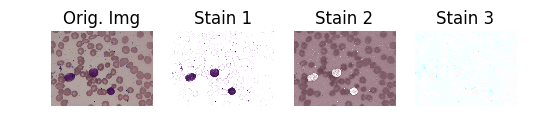

In [7]:
plot_deconvolution(model,'sdlayer_1',img)

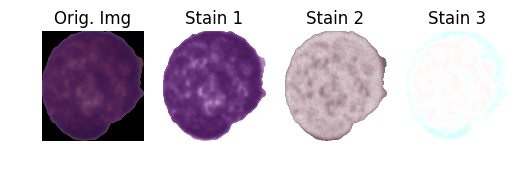

In [8]:
img_nucleus = imread('hemat_Segmentation_Output_H12_18_4.BMP')
plot_deconvolution(model,'sdlayer_1',img_nucleus)